# Video Game Sales

The dataset contains a list of video games with sales greater than 100,000 copies, which was generated by a scrape of [vgcharts.com](vgchartz.com)

## Contents
This dataset is totally based on the dataset released on [Kaggle's Video Games dataset](https://www.kaggle.com/gregorut/videogamesales). There are 16,598 records. 2 records were dropped by the releaser due to incomplete information.


# Import Data and Library

In [ ]:
# Import Library 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import re
# Import Data
df = pd.read_csv('vgsales.csv')

# 1. Brief Examination

In [ ]:
# Get a glimpse of how the dataset look like
df.head()

In [ ]:
# Get to see the general frame of the dataset
df.info()

In [ ]:
df.shape


## Dataset Attributes Explanation
So far so good! There are 11 columns in total which demonstrate 11 attributes as follow:
1. Rank - Ranking of overall sales
2. Name - The games name
3. Platform - Platform of the games released (i.e. PC,PS4, etc.)
4. Year - Year of the game's release
5. Genre - Genre of the game
6. Publisher - Publisher of the game
7. NA_Sales - Sales in North America (in millions)
8. EU_Sales - Sales in Europe (in millions)
9. JP_Sales - Sales in Japan (in millions)
10. Other_Sales - Sales in the rest of the world (in millions)
11. Global_Sales - Total worldwide sales. 

Before we move on the next step of the data-cleaning, there are 2 things to keep in mind: all the sales number recored are satisfied the over-100k-copy condition, and the unit of the sales numbers is millions USD.

## Questions
After looking through swiftly at the dataset, our team come up with some interesting questions about the development of the video games industry:
### 1. About The Video Games Market
- What is the market size of the video games industry? 
- Who are the big markets and the associated market shares? 
- What are the development patterns of the video games market?

### 2. About the Video Games Manufacturers and Developers
- What is the ratio between total sales by video games in general and the sales of game consoles?
- What is the optimal platform for game developers to release their games on?

### 3. About The Video Games Genre
- How have the video games genre been prefered over the years?
- Which factors might have caused any changes in the genre preferences?

# Data Cleaning

### Data deduplication

At the start let check to see whether there are any duplicated rows.
We can try to easy way first:

In [ ]:
df.duplicated().sum()

0

So on surface, it seems like we don't have any duplicated rows. However, let look again at our data.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


We can see that there are a really interesting cell, namely "Rank". If the "Rank" is sorted correctly, we will not be able to see any duplicated row just from using the above method. Let's see if the "Rank" clean. 

In [ ]:
df['Rank'].duplicated().sum()

0

In [ ]:
df['Rank'].nunique()

16598

Since its unique value equal the info, we can conclude that it's sorted correctly. Thus, we can't do the easy method above. Let's try some specific row such as "Name".

In [ ]:
df['Name'].duplicated().sum()

5105

Jackpot! But is it? As mentioned above, the "Name" column is associated with "Platform" column, where each game can be release for multiple platform. Let's see closer between these and just pick the correct duplicated rows, which have the same "Name" and "Platform".

In [ ]:
#Groupby the name and count the number of occurences of "Platform". 
df_name = df.groupby('Name')['Platform'].count().reset_index()

#We only interested in > 1 occurences.
duplicated_name = df_name[df_name['Platform'] != 1]['Name'].reset_index()

#Now we can try to see for every game that have > 1 occurences in our data, how many of those have the same platform,
#which we will deemed it to be duplicated.
tmp = []
for i in range(len(duplicated_name)):
    if df[df['Name'] == duplicated_name['Name'][i]]['Platform'].nunique() == 1:
        tmp.append(duplicated_name['Name'][i])
print(duplicated_name) #Let's see how many non 1 occurences name
print(tmp) #Let's see how many real duplicated name we have

      index                              Name
0        12            007: Quantum of Solace
1        13      007: The World is not Enough
2        28                 11eyes: CrossOver
3        34  18 Wheeler: American Pro Trucker
4        37                  187: Ride or Die
...     ...                               ...
2770  11478                            iCarly
2771  11479        iCarly 2: iJoin The Click!
2772  11483                            nail'd
2773  11484         pro evolution soccer 2011
2774  11490      uDraw Studio: Instant Artist

[2775 rows x 2 columns]
['Wii de Asobu: Metroid Prime']


Let's see if 'Wii de Asobu: Metroid Prime' is actually duplicated

In [ ]:
df[df['Name'] == 'Wii de Asobu: Metroid Prime']

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
14997,15000,Wii de Asobu: Metroid Prime,Wii,NaN,Shooter,Nintendo,0.0,0.0,0.02,0.0,0.02
14999,15002,Wii de Asobu: Metroid Prime,Wii,NaN,Shooter,Nintendo,0.0,0.0,0.02,0.0,0.02


Alright, so for we can see that not only it's duplicated but it also has null values. We'll wait until null value processing to decide what to do with it. Which is the next step :D

### Null values

First, let's see how many null values are there and their location (columns)

In [ ]:
df.isnull().sum()

Rank            0
Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64

Alright, so there are couples of null values in "Year" and "Publisher". Unfortunately, all others columns aren't provided us any useful information to approximate these null values. So we decided that we will drop all null values. There are 2 main reasons: 
1. As mentioned, there aren't good information to use to approximate.
2. % of null values is minimal (1.6% for "Year" and 0.3% for "Publisher") and the impact of dropping these null values is immaterial.

In [ ]:
df = df.dropna()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16291 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16291 non-null  int64  
 1   Name          16291 non-null  object 
 2   Platform      16291 non-null  object 
 3   Year          16291 non-null  float64
 4   Genre         16291 non-null  object 
 5   Publisher     16291 non-null  object 
 6   NA_Sales      16291 non-null  float64
 7   EU_Sales      16291 non-null  float64
 8   JP_Sales      16291 non-null  float64
 9   Other_Sales   16291 non-null  float64
 10  Global_Sales  16291 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


### Mislabeled data

Let's see if there are any mislabeled in categorical data. Due to the nature of data, we assume that the number of  "Platform" and "Genre" will be small and "Name" and "Publisher" will be large. 

In [ ]:
#Check unique value Platform
print(df['Platform'].unique())

#Check unique value Genre
print(df['Genre'].unique())


['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' '3DS' 'PS4' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'GC' 'WiiU' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']
['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy']


In [ ]:
#Check unique value Name
print(df['Name'].nunique())

#Check unique value Publisher
print(df['Publisher'].nunique())


11325
576


We can see that there's nothing wrong in "Platform" and "Genre". Let's see if there're any weird behavior in "Name" and "Publisher".
We assume that in a name of a game, it usually contains characters (a-z, A-Z), numbers (0-9), some special character such as (? , .). The same apply for "Publisher". Let's see if we find any abnormalities.

In [ ]:
def check_character(row):
    pattern = r'[^a-zA-Z0-9\?\,\.\-\:]'
    if re.match(pattern,row['Name']) == None:
        return 0
    else:
        return 1

abnormal_name = df.apply(check_character,axis = 1)
abnormal_name = abnormal_name.reset_index()
for i in abnormal_name[abnormal_name[0] == 1]['index']:
    print(df.iloc[int(i-1)]['Name'])

SingStar '80s
Guitar Hero: Aerosmith
Star Ocean: The Last Hope
Midnight Club 3: DUB Edition
RR64: Ridge Racer 64
Vampire Night
Sol Trigger


In [ ]:
def check_character(row):
    pattern = r'[^a-zA-Z0-9\?\,\.\-\:]'
    if re.match(pattern,row['Publisher']) == None:
        return 0
    else:
        return 1

abnormal_publisher = df.apply(check_character,axis = 1)
abnormal_publisher = abnormal_publisher.reset_index()
for i in abnormal_publisher[abnormal_publisher[0] == 1]['index']:
    print(df.iloc[int(i-1)]['Publisher'])

So we can observe that for 7 cases where our regex catch, the name seem normal and none cases for publisher. Thus, we can conclude that there are no mislabeled data.

### Format Data

Let's look again at our data info

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16291 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16291 non-null  int64  
 1   Name          16291 non-null  object 
 2   Platform      16291 non-null  object 
 3   Year          16291 non-null  float64
 4   Genre         16291 non-null  object 
 5   Publisher     16291 non-null  object 
 6   NA_Sales      16291 non-null  float64
 7   EU_Sales      16291 non-null  float64
 8   JP_Sales      16291 non-null  float64
 9   Other_Sales   16291 non-null  float64
 10  Global_Sales  16291 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 2.0+ MB


We can see that there are most of the data format is fine, except 1 column "Year". We decided that it need to be change to int type instead of float, as every year is an integer. 

In [ ]:
df['Year'] = df['Year'].astype(int)

In [ ]:
#overall info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16291 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16291 non-null  int64  
 1   Name          16291 non-null  object 
 2   Platform      16291 non-null  object 
 3   Year          16291 non-null  int64  
 4   Genre         16291 non-null  object 
 5   Publisher     16291 non-null  object 
 6   NA_Sales      16291 non-null  float64
 7   EU_Sales      16291 non-null  float64
 8   JP_Sales      16291 non-null  float64
 9   Other_Sales   16291 non-null  float64
 10  Global_Sales  16291 non-null  float64
dtypes: float64(5), int64(2), object(4)
memory usage: 2.0+ MB


# **EDA categorical**

In [ ]:
#statistical info
df.describe(include= 'all')

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16291.000000,16291,16291,16291.000000,16291,16291,16291.000000,16291.000000,16291.000000,16291.000000,16291.000000
unique,NaN,11325,31,NaN,12,576,NaN,NaN,NaN,NaN,NaN
top,NaN,Need for Speed: Most Wanted,DS,NaN,Action,Electronic Arts,NaN,NaN,NaN,NaN,NaN
freq,NaN,12,2131,NaN,3251,1339,NaN,NaN,NaN,NaN,NaN
mean,8290.190228,NaN,NaN,2006.405561,NaN,NaN,0.265647,0.147731,0.078833,0.048426,0.540910
std,4792.654450,NaN,NaN,5.832412,NaN,NaN,0.822432,0.509303,0.311879,0.190083,1.567345
min,1.000000,NaN,NaN,1980.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4132.500000,NaN,NaN,2003.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8292.000000,NaN,NaN,2007.000000,NaN,NaN,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12439.500000,NaN,NaN,2010.000000,NaN,NaN,0.240000,0.110000,0.040000,0.040000,0.480000


In [ ]:
# check mislabeled and corrupted data
print(df['Name'].unique())
print('--'*30)
print(df['Name'].nunique())
print('--'*30)
print(df['Name'].value_counts())

['Wii Sports' 'Super Mario Bros.' 'Mario Kart Wii' ... 'Plushees'
 'Woody Woodpecker in Crazy Castle 5' 'Know How 2']
------------------------------------------------------------
11325
------------------------------------------------------------
Need for Speed: Most Wanted                      12
FIFA 14                                           9
LEGO Marvel Super Heroes                          9
Ratatouille                                       9
LEGO Jurassic World                               8
                                                 ..
Dora the Explorer: Super Spies                    1
Wario Land II (GBC)                               1
Jam Sessions: Sing and Play Guitar (jp sales)     1
Aria: The Natural ~Tooi Yume no Mirage~           1
PO'ed                                             1
Name: Name, Length: 11325, dtype: int64


In [ ]:
# check mislabeled and corrupted data
print(df['Platform'].unique())
print('--'*30)
print(df['Platform'].nunique())
print('--'*30)
print(df['Platform'].value_counts())

['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' '3DS' 'PS4' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'GC' 'WiiU' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']
------------------------------------------------------------
31
------------------------------------------------------------
DS      2131
PS2     2127
PS3     1304
Wii     1290
X360    1234
PSP     1197
PS      1189
PC       938
XB       803
GBA      786
GC       542
3DS      499
PSV      410
PS4      336
N64      316
SNES     239
XOne     213
SAT      173
WiiU     143
2600     116
NES       98
GB        97
DC        52
GEN       27
NG        12
WS         6
SCD        6
3DO        3
TG16       2
PCFX       1
GG         1
Name: Platform, dtype: int64


In [ ]:
# check mislabeled and corrupted data
print(df['Year'].unique())
print('--'*30)
print(df['Year'].nunique())
print('--'*30)
print(df['Year'].value_counts())

[2006 1985 2008 2009 1996 1989 1984 2005 1999 2007 2010 2013 2004 1990
 1988 2002 2001 2011 1998 2015 2012 2014 1992 1997 1993 1994 1982 2003
 1986 2000 1995 2016 1991 1981 1987 1980 1983 2020 2017]
------------------------------------------------------------
39
------------------------------------------------------------
2009    1431
2008    1428
2010    1257
2007    1201
2011    1136
2006    1008
2005     936
2002     829
2003     775
2004     744
2012     655
2015     614
2014     580
2013     546
2001     482
1998     379
2000     349
2016     342
1999     338
1997     289
1996     263
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1989      17
1983      17
1990      16
1987      16
1988      15
1985      14
1984      14
1980       9
2017       3
2020       1
Name: Year, dtype: int64


In [ ]:
# check mislabeled and corrupted data
print(df['Genre'].unique())
print('--'*30)
print(df['Genre'].nunique())
print('--'*30)
print(df['Genre'].value_counts())

['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy']
------------------------------------------------------------
12
------------------------------------------------------------
Action          3251
Sports          2304
Misc            1686
Role-Playing    1470
Shooter         1282
Adventure       1274
Racing          1225
Platform         875
Simulation       848
Fighting         836
Strategy         670
Puzzle           570
Name: Genre, dtype: int64


In [ ]:
# check mislabeled and corrupted data
print(df['Publisher'].unique())
print('--'*30)
print(df['Publisher'].nunique())
print('--'*30)
print(df['Publisher'].value_counts())

['Nintendo' 'Microsoft Game Studios' 'Take-Two Interactive'
 'Sony Computer Entertainment' 'Activision' 'Ubisoft' 'Bethesda Softworks'
 'Electronic Arts' 'Sega' 'SquareSoft' 'Atari' '505 Games' 'Capcom'
 'GT Interactive' 'Konami Digital Entertainment'
 'Sony Computer Entertainment Europe' 'Square Enix' 'LucasArts'
 'Virgin Interactive' 'Warner Bros. Interactive Entertainment'
 'Universal Interactive' 'Eidos Interactive' 'RedOctane' 'Vivendi Games'
 'Enix Corporation' 'Namco Bandai Games' 'Palcom' 'Hasbro Interactive'
 'THQ' 'Fox Interactive' 'Acclaim Entertainment' 'MTV Games'
 'Disney Interactive Studios' 'Majesco Entertainment' 'Codemasters'
 'Red Orb' 'Level 5' 'Arena Entertainment' 'Midway Games' 'JVC'
 'Deep Silver' '989 Studios' 'NCSoft' 'UEP Systems' 'Parker Bros.' 'Maxis'
 'Imagic' 'Tecmo Koei' 'Valve Software' 'ASCII Entertainment' 'Mindscape'
 'Infogrames' 'Unknown' 'Square' 'Valve' 'Activision Value' 'Banpresto'
 'D3Publisher' 'Oxygen Interactive' 'Red Storm Entertainment'
 

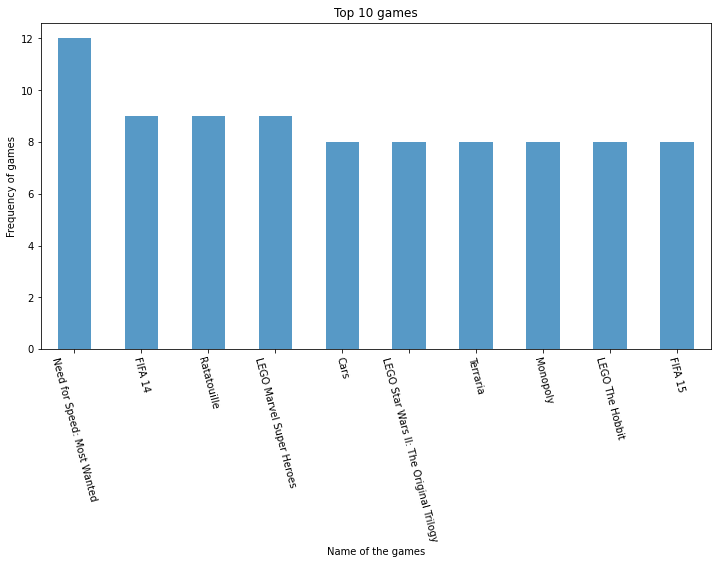

In [ ]:
# top 10 games
plt.figure()
top_10_game = df['Name'].value_counts().head(10).plot(kind='bar',figsize=(12,6),xlabel="Name of the games",ylabel='Frequency of games',alpha=0.75, rot=-75)
plt.title("Top 10 games")
plt.show()

**Comment:**
As we can see, Need for speed: Most wanted was the most popular game during the whole period. Second on the list were Fifa 14, Lego,..
 

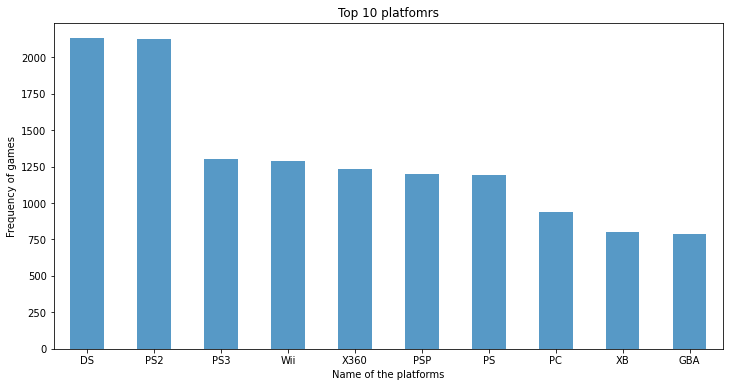

In [ ]:
# top 10 platforms
plt.figure()
top_10_platforms = df['Platform'].value_counts().head(10).plot(kind='bar',figsize=(12,6),xlabel="Name of the platforms",ylabel='Frequency of games',alpha=0.75,rot=0)
plt.title("Top 10 platfomrs")
plt.show()

**Comment:** Top of the list were DS and PS2 with far more popular than the rest.

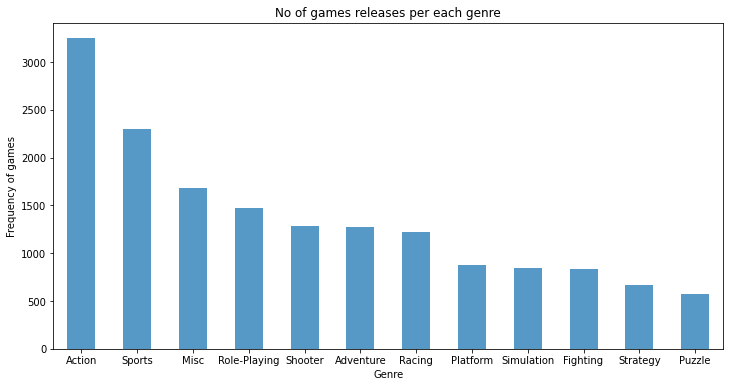

In [ ]:
# Genre
plt.figure()
genres = df['Genre'].value_counts().plot(kind='bar',figsize=(12,6),xlabel="Genre",ylabel='Frequency of games',alpha=0.75, rot =0)
plt.title("No of games releases per each genre")
plt.show()

**Comment:** Interestingly, Action was the most prominent genre, while Strategy and Puzzle were ranked at the bottom.

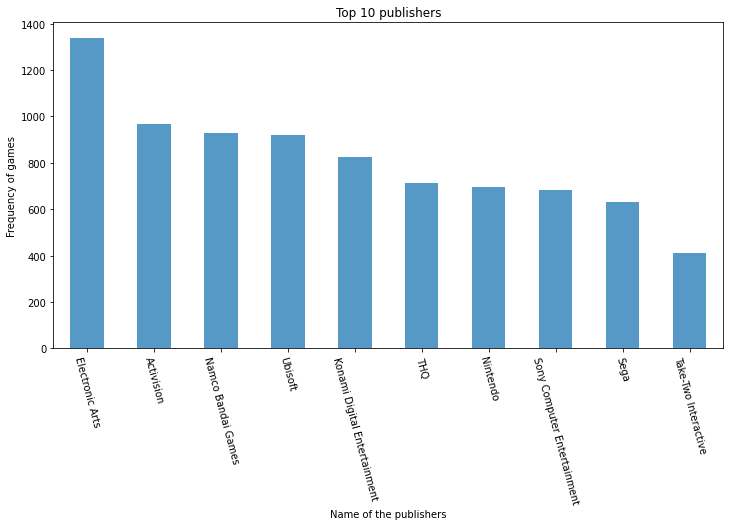

In [ ]:
# Top 10 Publishers
plt.show()
top_10_publisher = df['Publisher'].value_counts().head(10).plot(kind='bar',figsize=(12,6),xlabel="Name of the publishers",ylabel='Frequency of games',alpha=0.75, rot= -75)
plt.title('Top 10 publishers')
plt.show()

**Comment:** Electronic Arts was the most famous publisher compared with the rest.

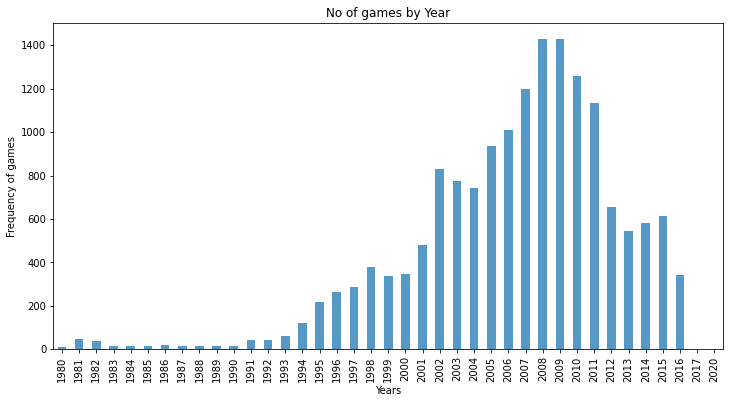

In [ ]:
# No of games by Year
plt.figure()
year = df['Year'].value_counts().sort_index().plot(kind='bar',figsize=(12,6),xlabel="Years",ylabel='Frequency of games',alpha=0.75)
plt.title("No of games by Year")
plt.show()

**Comment:** The majority of games was released between 2005 and 2011

# **EDA numerical**

In [ ]:
# Overview data using describe
df.describe()

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16291.000000,16291.000000,16291.000000,16291.000000,16291.000000,16291.000000,16291.000000
mean,8290.190228,2006.405561,0.265647,0.147731,0.078833,0.048426,0.540910
std,4792.654450,5.832412,0.822432,0.509303,0.311879,0.190083,1.567345
min,1.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4132.500000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8292.000000,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12439.500000,2010.000000,0.240000,0.110000,0.040000,0.040000,0.480000
max,16600.000000,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000


## **Caculate Quantile NA, EU, Other, Global**

In [ ]:
# Calculate the quantiles NA_sales
q1_NA = df['NA_Sales'].quantile(0.25) # Tính Q1
q3_NA = df['NA_Sales'].quantile(0.75) # Tính Q3 

# Calculate the interquantile range
iqr_NA = q3_NA - q1_NA

# Calculate the whisker
upper_whisker_NA = q3_NA + 1.5*iqr_NA
lower_whisker_NA = q1_NA - 1.5*iqr_NA
print(upper_whisker_NA)
print(lower_whisker_NA)

0.6
-0.36


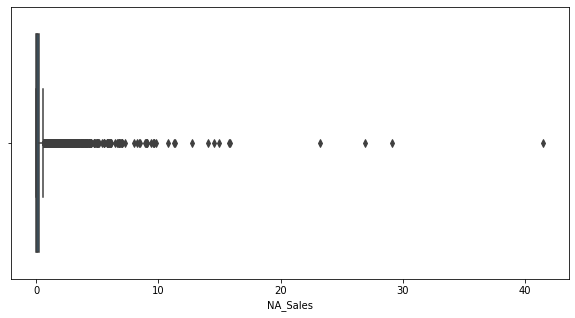

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data = df,
            x = df['NA_Sales'])
plt.show()

In [ ]:
# Calculate the quantiles EU_sales
q1_EU = df['EU_Sales'].quantile(0.25) # Tính Q1
q3_EU = df['EU_Sales'].quantile(0.75) # Tính Q3 

# Calculate the interquantile range
iqr_EU = q3_EU - q1_EU

# Calculate the whisker
upper_whisker_EU = q3_EU + 1.5*iqr_EU
lower_whisker_EU = q1_EU - 1.5*iqr_EU
print(upper_whisker_EU)
print(lower_whisker_EU)

0.275
-0.165


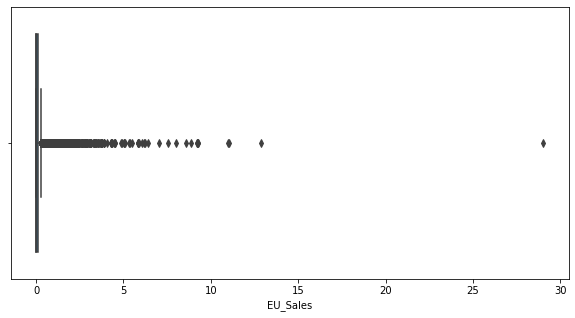

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data = df,
            x = df['EU_Sales'])
plt.show()

In [ ]:
# Calculate the quantiles Japan_sales
q1_JP = df['JP_Sales'].quantile(0.25) # Tính Q1
q3_JP = df['JP_Sales'].quantile(0.75) # Tính Q3 

# Calculate the interquantile range
iqr_JP = q3_JP - q1_JP

# Calculate the whisker
upper_whisker_JP = q3_JP + 1.5*iqr_JP
lower_whisker_JP = q1_JP - 1.5*iqr_JP
print(upper_whisker_JP)
print(lower_whisker_JP)

0.1
-0.06


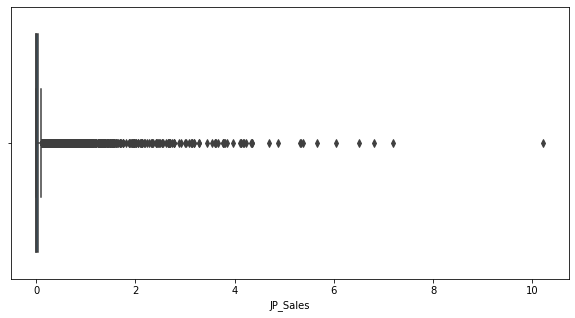

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data = df,
            x = df['JP_Sales'])
plt.show()

In [ ]:
# Calculate the quantiles Orther_sales
q1_Orther = df['Other_Sales'].quantile(0.25) # Tính Q1
q3_Orther = df['Other_Sales'].quantile(0.75) # Tính Q3 

# Calculate the interquantile range
iqr_Orther = q3_Orther - q1_Orther

# Calculate the whisker
upper_whisker_Orther = q3_Orther + 1.5*iqr_Orther
lower_whisker_Orther = q1_Orther - 1.5*iqr_Orther
print(upper_whisker_Orther)
print(lower_whisker_Orther)

0.1
-0.06


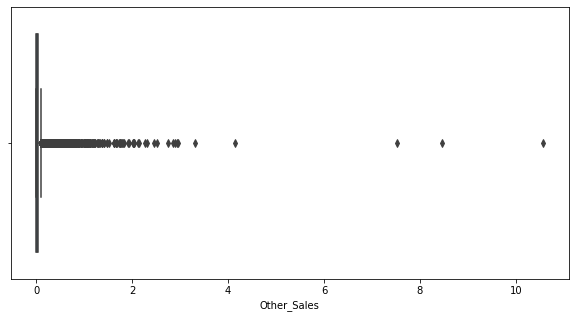

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data = df,
            x = df['Other_Sales'])
plt.show()

In [ ]:
# Calculate the quantiles Global_sales
q1_Global = df['Global_Sales'].quantile(0.25) # Tính Q1
q3_Global = df['Global_Sales'].quantile(0.75) # Tính Q3 

# Calculate the interquantile range
iqr_Global = q3_Global - q1_Global

# Calculate the whisker
upper_whisker_Global = q3_Global + 1.5*iqr_Global
lower_whisker_Global = q1_Global - 1.5*iqr_Global
print(upper_whisker_Global)
print(lower_whisker_Global)

1.1099999999999999
-0.5700000000000001


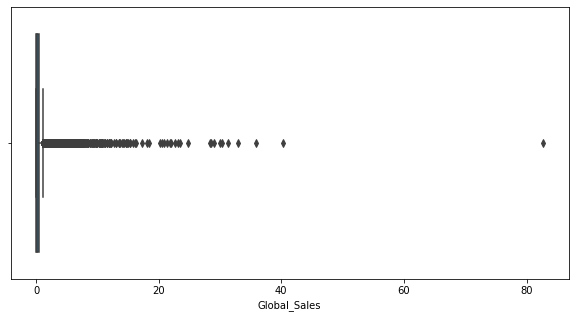

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data = df,
            x = df['Global_Sales'])
plt.show()

**Comment**
  * we can see in each area found 1 outliner

In [ ]:
max_NA = df[df['NA_Sales'] == (df['NA_Sales'].max())]
max_EU = df[df['EU_Sales'] == (df['EU_Sales'].max())]
max_JP = df[df['JP_Sales'] == (df['JP_Sales'].max())]
max_Other = df[df['Other_Sales'] == (df['Other_Sales'].max())]
max_Global = df[df['Global_Sales'] == (df['Global_Sales'].max())]

max_NA

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Manufacturer
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,Nintendo


In [ ]:
max_EU

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Manufacturer
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,Nintendo


In [ ]:
max_JP

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Manufacturer
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.0,31.37,Nintendo


In [ ]:
max_Other

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Manufacturer
17,18,Grand Theft Auto: San Andreas,PS2,2004.0,Action,Take-Two Interactive,9.43,0.4,0.41,10.57,20.81,Sony


In [ ]:
max_Global

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Manufacturer
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,Nintendo


**Comment**
*   In NA and EU top game is Wii Sports	because this is a group 5 games and family can play together
*   Meanwhile in Japan, this is the country of pokemon lovers, so sales of pokemon games are high




## **Chart**

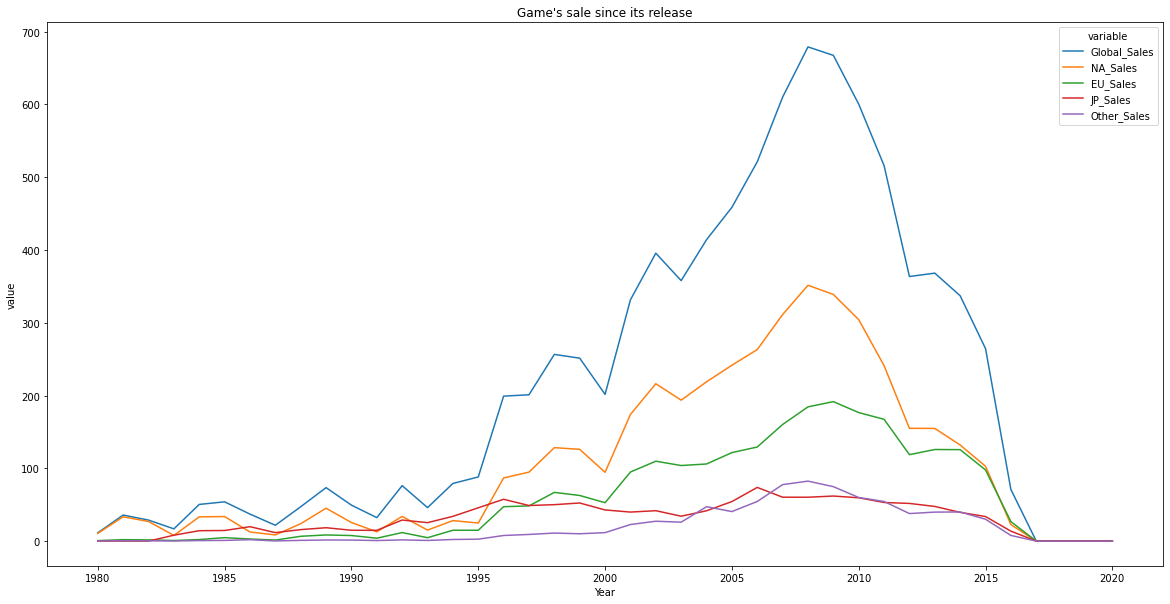

In [ ]:
sales_by_year = df.groupby(['Year']).sum()[['Global_Sales','NA_Sales','EU_Sales','JP_Sales','Other_Sales']].reset_index()
plt.figure(figsize=(20,10))
sns.lineplot(x='Year',y='value',hue='variable',data=pd.melt(sales_by_year,['Year']))
plt.title("Game's sale since its release")
plt.show()

**Comment**


*   1980 to 1995: only NA and Japan have a hight sale but from 2000 to 2015: EU and NA become 2 big arena



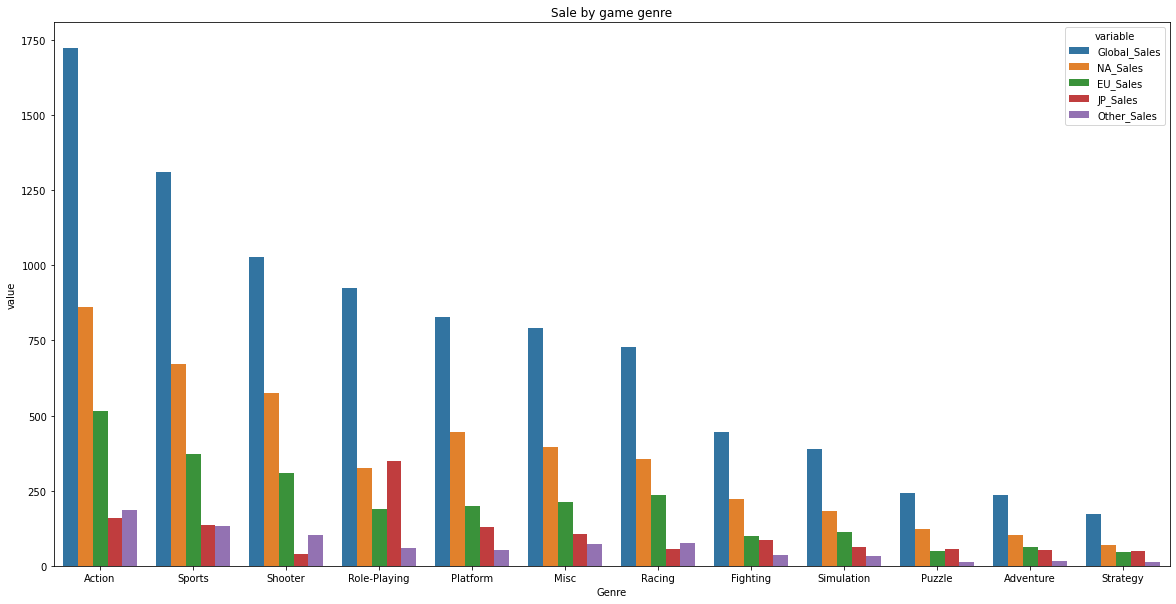

In [ ]:
sales_by_Genre = df.groupby('Genre')[['Global_Sales','NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum().reset_index().sort_values('Global_Sales', ascending = False)
plt.figure(figsize=(20,10))
sns.barplot(x='Genre',y='value',hue='variable',data=pd.melt(sales_by_Genre,['Genre']))
plt.title('Sale by game genre')
plt.show()

**Comment**


*   Action, Sports, Shooter is 3 big Genre lover of gamer on NA and EU, but in Japan's gamer lover Role Player more than Shooter



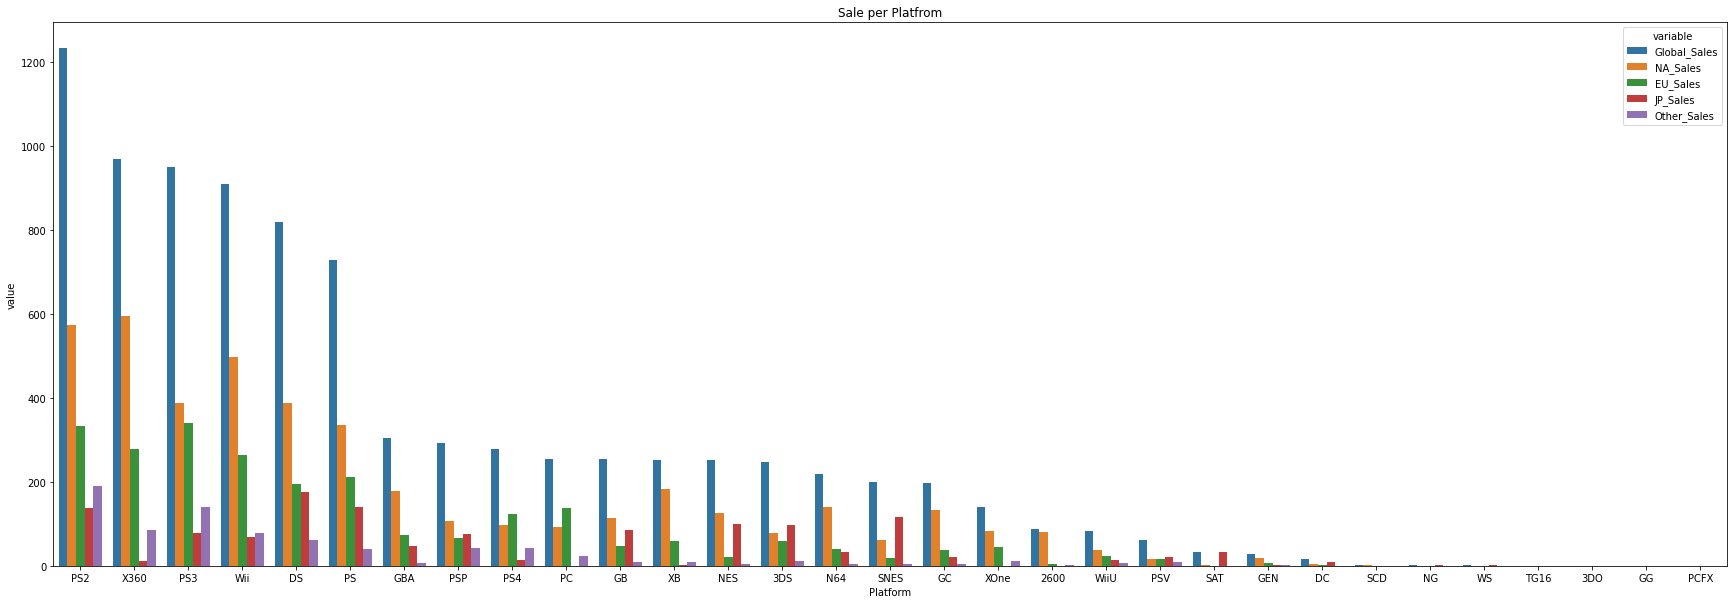

In [ ]:
sales_by_Platform = df.groupby('Platform')[['Global_Sales','NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum().reset_index().sort_values('Global_Sales', ascending = False)
plt.figure(figsize=(30,10))
sns.barplot(x='Platform',y='value',hue='variable',data=pd.melt(sales_by_Platform,['Platform']))
plt.title('Sale per Platfrom')
plt.show()

**Comment**

*   PS2 release in 2000, but this is a platform most lover



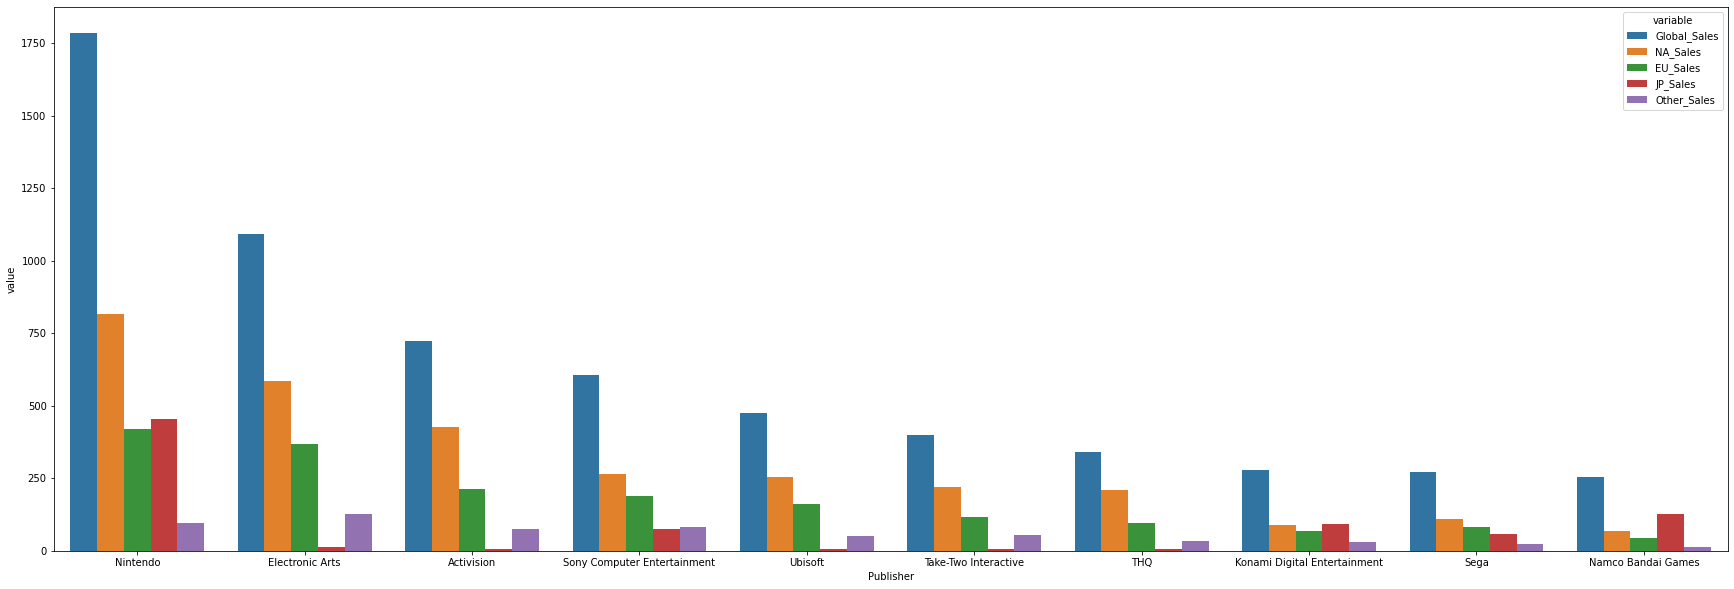

In [ ]:
sales_by_Publisher = df.groupby('Publisher')[['Global_Sales','NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum().reset_index().sort_values('Global_Sales', ascending = False).head(10)
plt.figure(figsize=(30,10))
sns.barplot(x='Publisher',y='value',hue='variable',data=pd.melt(sales_by_Publisher,['Publisher']))
plt.show()

**Comment**


*   Nintendo, Electronic Arts, Activision is a 3 big Publisher on the world, but in Japan Nintendo is a most Publisher lover 


